In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import geopandas as gpd
import pandas as pd
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import cartopy.crs as ccrs
from cartopy.crs import PlateCarree as plate
import cartopy.io.shapereader as shpreader

import xarray as xr
import atlite

from shapely.geometry import Point
from shapely.geometry import Polygon

import logging
import warnings

warnings.simplefilter('always', DeprecationWarning)
logging.captureWarnings(True)
logging.basicConfig(level=logging.INFO)

In [2]:
# Create cutout that will call ERA5 data over specified geospatial slice when prepared. The resolution is of 0.25x0.25 (lat,long)
# In this case, cutout is only of January of the year 2011 over the region of Africa's southern region

# Must choose cutout_dir that is in the same directory as atlite folder

## If the cutout file has already been prepared, then this line of code will call that dataset,

cutout = atlite.Cutout(name="SA-2011-01-V4",
                       cutout_dir="/Users/lennon/Documents/GitHub/Sites/obeles.github.io/india_electricity/output_data",
                       module="era5",
                       xs=slice(12.319845, 36.469981316000087 ),
                       ys=slice(-21.564172, -35.851490),
                       years=slice(2011, 2011),
                       months=slice(1,1))


## Actually does all the heavy lifting of calling the data and preparing the NETCDF file (.nc). Stores this file in your computer under your configured file directory.
## Can open these files using xarray. These xarray files have raw ERA5 data before processing for atlite's output, so can potentially pull wind series directly from here. Still have to figure out how to do this though.
## Took my computer ~20 minutes to prepare 744 hour series (January 2011)

## IMPORTANT: Must erase this part of the script once cutout has been prepared/



INFO:atlite.cutout:Assuming a view into the prepared cutout: <Cutout SA-2011-01-V4 x=12.50-36.25 y=-21.75--35.75 time=2011/1-2011/1 prepared>


In [11]:
# Code that creates a MultiPolygon of the shape of South Africa
shpfilename = shpreader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
SthAfr = gpd.GeoSeries({r.attributes['NAME_EN']: r.geometry
                      for r in reader.records()},
                     crs={'init': 'epsg:4326'}
                     ).reindex(['South Africa'])

projection = ccrs.Orthographic(-28, 26) 


# Creates gridcells geopandas dataframe based off of gridcells of the cutout
cells = gpd.GeoDataFrame({'geometry': cutout.grid_cells,
                          'capfactors': None,
                          'x': cutout.grid_coordinates()[:, 0],
                          'y': cutout.grid_coordinates()[:, 1]})

In [7]:
# Creates geopandas dataframe with coordinates, optimized tilt and azimuthal angles, and installed capacity of desired sites. 
# As of right now, must specify all 5 sites for script to work. Will soon implement code to adjust to amount of sites desired.
# THIS PART OF THE SCRIPT IS IMPORTANT BECAUSE IT IS WHERE WE SPECIFY THE COORDINATES AND INSTALLED CAPACITY OF EACH SITE
# For selection can go to https://globalsolaratlas.info/map, select desired sites, and fill in the coordinates, optimal tilt and azimuthal values, and desired installed capacity

pv_sites = gpd.GeoDataFrame([['site_0', 18.294983, -29.683281, 30 ,0 , 5],
                          ['site_1', 22.111359, -30.975843, 30, 0,  5],
                          ['site_2', 21.125336, -32.157012, 31, 0,  5],
                          ['site_3', 27.725372, -26.466885, 29, 0,  5],
                          ['site_4', 18.047791, -32.908415, 29, 0,  5]],
                         columns=['name', 'x', 'y','optimal slope', 'optimal azimuthal', 'capacity']
                         ).set_index('name')

In [5]:
# 



Convert and aggregate `pv`: 100% (1 of 1) || Elapsed Time: 0:00:01 Time:  0:00:01


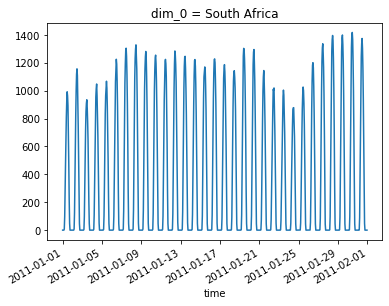

In [6]:
# Example plot of wind power generation in all of South Africa
# Data is saved in the form of Xarray (http://xarray.pydata.org/en/stable/index.html)

pv_power_0 = cutout.pv('CdTe',orientation={'slope': 30, 'azimuth': 0}, shapes=SthAfr.geometry)

pv_power_0.plot()

In [14]:
pv_sites

,x,y,optimal slope,optimal azimuthal,capacity
name,,,,,
site_0,18.14,-29.38,218,27.4,5
site_1,22.32,-32.55,223,40.9,5
site_2,19.37,-32.49,217,34.0,5
site_3,27.39,-26.27,260,45.1,5
site_4,20.53,-32.36,230,30.8,5


In [8]:
# Place holder to be used for layout
cap_factors_pv_0 = cutout.pv('CdTe', capacity_factor=True,
                           orientation={'slope': 30, 'azimuth': 0})

# Assigns assigned sites to specific cells of the cutout grid

pv_nearest = cap_factors_pv_0.sel(
    {'x': pv_sites.x.values, 'y': pv_sites.y.values}, 'nearest').coords
pv_sites['x'] = pv_nearest.get('x').values
pv_sites['y'] = pv_nearest.get('y').values
cells_generation_pv = pv_sites.merge(
    cells, how='inner').rename(pd.Series(pv_sites.index))

cells_generation_pv = pv_sites.merge(
    cells, how='inner').rename(pd.Series(pv_sites.index))

layout_pv = xr.DataArray(cells_generation_pv.set_index(['y', 'x']).capacity.unstack())\
                    .reindex_like(cap_factors_pv_0).rename('Installed Capacity [MW]')

Convert and aggregate `pv`: 100% (1 of 1) || Elapsed Time: 0:00:01 Time:  0:00:01


In [21]:
cap_factors_pv_0

<xarray.DataArray (y: 57, x: 96)>
array([[0.22034786, 0.22261313, 0.22454721, ..., 0.20456288, 0.20727296,
        0.20799309],
       [0.22117244, 0.22292686, 0.22428397, ..., 0.20125511, 0.2055357 ,
        0.20792976],
       [0.22150711, 0.2229593 , 0.22389116, ..., 0.19776249, 0.20542573,
        0.20806489],
       ...,
       [0.23893492, 0.23826822, 0.23797659, ..., 0.21311549, 0.21185817,
        0.21068324],
       [0.23941397, 0.23858773, 0.23826858, ..., 0.21762784, 0.21649054,
        0.21533101],
       [0.24042131, 0.23986952, 0.23964022, ..., 0.22125813, 0.22027705,
        0.21934294]])
Coordinates:
  * y        (y) float32 -21.75 -22.0 -22.25 -22.5 ... -35.0 -35.25 -35.5 -35.75
    lat      (y) float32 -21.75 -22.0 -22.25 -22.5 ... -35.0 -35.25 -35.5 -35.75
  * x        (x) float32 12.5 12.75 13.0 13.25 13.5 ... 35.5 35.75 36.0 36.25
    lon      (x) float32 12.5 12.75 13.0 13.25 13.5 ... 35.5 35.75 36.0 36.25

In [9]:
from shapely.geometry import Polygon
import folium

# In order to calculate power generation or CF of each coordinate, we actually create small 0.25x0.25 polygons
# that contain each one of the cutout cells data in them


# Creating the long lat points to then create polygon
lon_point_list_0 = [pv_sites['x'][0]-0.125, pv_sites['x'][0]-0.125, pv_sites['x'][0]+0.125, pv_sites['x'][0]+0.125]
lon_point_list_1 = [pv_sites['x'][1]-0.125, pv_sites['x'][1]-0.125, pv_sites['x'][1]+0.125, pv_sites['x'][1]+0.125]
lon_point_list_2 = [pv_sites['x'][2]-0.125, pv_sites['x'][2]-0.125, pv_sites['x'][2]+0.125, pv_sites['x'][2]+0.125]
lon_point_list_3 = [pv_sites['x'][3]-0.125, pv_sites['x'][3]-0.125, pv_sites['x'][3]+0.125, pv_sites['x'][3]+0.125]
lon_point_list_4 = [pv_sites['x'][4]-0.125, pv_sites['x'][4]-0.125, pv_sites['x'][4]+0.125, pv_sites['x'][4]+0.125]

lat_point_list_0 = [pv_sites['y'][0]+0.125, pv_sites['y'][0]-0.125, pv_sites['y'][0]-0.125, pv_sites['y'][0]+0.125]
lat_point_list_1 = [pv_sites['y'][1]+0.125, pv_sites['y'][1]-0.125, pv_sites['y'][1]-0.125, pv_sites['y'][1]+0.125]
lat_point_list_2 = [pv_sites['y'][2]+0.125, pv_sites['y'][2]-0.125, pv_sites['y'][2]-0.125, pv_sites['y'][2]+0.125]
lat_point_list_3 = [pv_sites['y'][3]+0.125, pv_sites['y'][3]-0.125, pv_sites['y'][3]-0.125, pv_sites['y'][3]+0.125]
lat_point_list_4 = [pv_sites['y'][4]+0.125, pv_sites['y'][4]-0.125, pv_sites['y'][4]-0.125, pv_sites['y'][4]+0.125]

# Creates polygon from above lat long points
polygon_geom_0 = Polygon(zip(lon_point_list_0, lat_point_list_0))
crs_0 = {'init': 'epsg:4326'}
polygon_pv_0 = gpd.GeoDataFrame(index=[0], crs=crs_0, geometry=[polygon_geom_0])

polygon_geom_1 = Polygon(zip(lon_point_list_1, lat_point_list_1))
crs_1 = {'init': 'epsg:4326'}
polygon_pv_1 = gpd.GeoDataFrame(index=[0], crs=crs_1, geometry=[polygon_geom_1])

polygon_geom_2 = Polygon(zip(lon_point_list_2, lat_point_list_2))
crs_2 = {'init': 'epsg:4326'}
polygon_pv_2 = gpd.GeoDataFrame(index=[0], crs=crs_2, geometry=[polygon_geom_2])

polygon_geom_3 = Polygon(zip(lon_point_list_3, lat_point_list_3))
crs_3 = {'init': 'epsg:4326'}
polygon_pv_3 = gpd.GeoDataFrame(index=[0], crs=crs_3, geometry=[polygon_geom_3])

polygon_geom_4 = Polygon(zip(lon_point_list_4, lat_point_list_4))
crs_4 = {'init': 'epsg:4326'}
polygon_pv_4 = gpd.GeoDataFrame(index=[0], crs=crs_4, geometry=[polygon_geom_4])


# This code is just to see created on a map just in case. Below warnings are apparently related to this last bit of code
polygon_pv_0.to_file(filename='polygon_pv_0.geojson', driver='GeoJSON')
polygon_pv_0.to_file(filename='polygon_pv_0.shp', driver="ESRI Shapefile")


m = folium.Map([-30.46, 23.97766], zoom_start=5, tiles='cartodbpositron')
folium.GeoJson(polygon_pv_0).add_to(m)
folium.LatLngPopup().add_to(m)

  self, resource_name

  self, resource_name

ERROR:fiona._env:polygon_pv_0.geojson: No such file or directory
  DeprecationWarning,

  DeprecationWarning,

  DeprecationWarning,

  DeprecationWarning,



In [16]:
# This script outputs power generation of sites based off of the desired installed capacity.
# The PV used are CdTe panels
# Can input any geopandas GeoDataFrame, so potentially can input MapRE polygon zones here

pv_power_generation_0 = cutout.pv('CdTe', orientation={'slope': pv_sites['optimal slope'][0], 'azimuth': pv_sites['optimal azimuthal'][0]}, layout=layout_pv, 
                                  shapes=polygon_pv_0.geometry)
pv_power_generation_1 = cutout.pv('CdTe', orientation={'slope': pv_sites['optimal slope'][1], 'azimuth': pv_sites['optimal azimuthal'][1]}, layout=layout_pv, 
                                  shapes=polygon_pv_1.geometry)
pv_power_generation_2 = cutout.pv('CdTe', orientation={'slope': pv_sites['optimal slope'][2], 'azimuth': pv_sites['optimal azimuthal'][2]}, layout=layout_pv, 
                                  shapes=polygon_pv_2.geometry)
pv_power_generation_3 = cutout.pv('CdTe', orientation={'slope': pv_sites['optimal slope'][3], 'azimuth': pv_sites['optimal azimuthal'][3]}, layout=layout_pv, 
                                  shapes=polygon_pv_3.geometry)
pv_power_generation_4 = cutout.pv('CdTe', orientation={'slope': pv_sites['optimal slope'][4], 'azimuth': pv_sites['optimal azimuthal'][4]}, layout=layout_pv, 
                                  shapes=polygon_pv_4.geometry)



# Average of power generation
pv_power_generation_0_average = pv_power_generation_0.mean()
pv_power_generation_1_average = pv_power_generation_1.mean()
pv_power_generation_2_average = pv_power_generation_2.mean()
pv_power_generation_3_average = pv_power_generation_3.mean()
pv_power_generation_4_average = pv_power_generation_4.mean()

Convert and aggregate `pv`: 100% (1 of 1) || Elapsed Time: 0:00:01 Time:  0:00:01
Convert and aggregate `pv`: 100% (1 of 1) || Elapsed Time: 0:00:00 Time:  0:00:00
Convert and aggregate `pv`: 100% (1 of 1) || Elapsed Time: 0:00:00 Time:  0:00:00
Convert and aggregate `pv`: 100% (1 of 1) || Elapsed Time: 0:00:00 Time:  0:00:00
Convert and aggregate `pv`: 100% (1 of 1) || Elapsed Time: 0:00:00 Time:  0:00:00


In [13]:
# Translates power generation into CF, then calculates average.
# Still need to code this to automatically divide by particular installed capacity.


pv_cf_0 = pv_power_generation_0/pv_sites['capacity'][0]
pv_cf_1 = pv_power_generation_1/pv_sites['capacity'][1]
pv_cf_2 = pv_power_generation_2/pv_sites['capacity'][2]
pv_cf_3 = pv_power_generation_3/pv_sites['capacity'][3]
pv_cf_4 = pv_power_generation_4/pv_sites['capacity'][4]

pv_cf_0_average = pv_cf_0.mean()
pv_cf_1_average = pv_cf_1.mean()
pv_cf_2_average = pv_cf_2.mean()
pv_cf_3_average = pv_cf_3.mean()
pv_cf_4_average = pv_cf_4.mean()

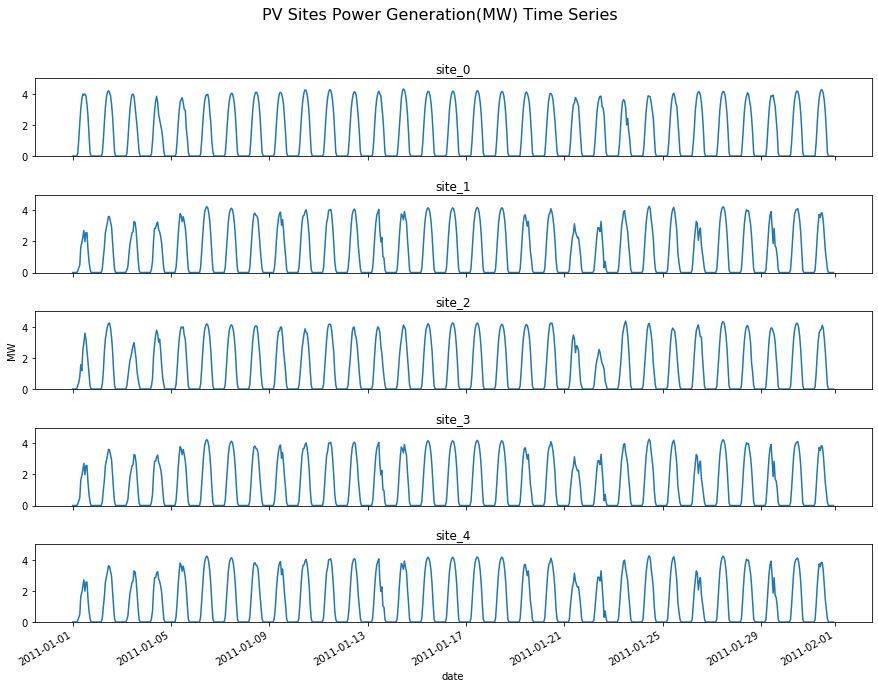

In [14]:
# Plot of solar power generation and CF of sites over time

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(len(pv_sites), figsize=(15,10))

pv_power_generation_0.plot(ax=ax1)
ax1.xaxis.set_label_text("")
ax1.xaxis.set_ticklabels([])
ax1.set_title("site_0")
ax1.set_ylim((0,pv_sites['capacity'][0]))

fig.suptitle('PV Sites Power Generation(MW) Time Series', fontsize=16)

pv_power_generation_1.plot(ax=ax2)
ax2.xaxis.set_label_text("")
ax2.xaxis.set_ticklabels([])
ax2.set_title("site_1")
ax2.set_ylim((0,pv_sites['capacity'][1]))
fig.subplots_adjust(hspace=0.5)

pv_power_generation_2.plot(ax=ax3)
ax3.xaxis.set_label_text("")
ax3.xaxis.set_ticklabels([])
ax3.set_title("site_2")
ax3.yaxis.set_label_text("MW")
ax3.set_ylim((0,pv_sites['capacity'][2]))
fig.subplots_adjust(hspace=0.5)

pv_power_generation_1.plot(ax=ax4)
ax4.xaxis.set_label_text("")
ax4.set_title("site_3")
ax4.xaxis.set_ticklabels([])
ax4.set_ylim((0,pv_sites['capacity'][3]))
fig.subplots_adjust(hspace=0.5)

pv_power_generation_1.plot(ax=ax5)
ax5.set_title("site_4")
ax5.xaxis.set_label_text("date")
ax5.set_ylim((0,pv_sites['capacity'][4]))
fig.subplots_adjust(hspace=0.5)


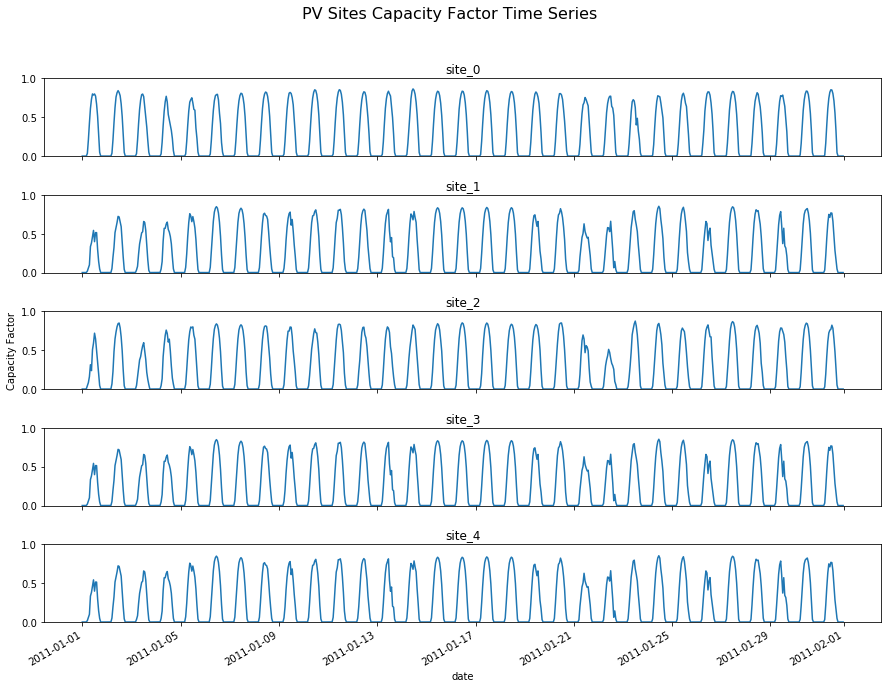

In [15]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(len(pv_sites), figsize=(15,10))

pv_cf_0.plot(ax=ax1)
ax1.xaxis.set_label_text("")
ax1.xaxis.set_ticklabels([])
ax1.set_title("site_0")
ax1.set_ylim((0,1))

fig.suptitle('PV Sites Capacity Factor Time Series', fontsize=16)

pv_cf_1.plot(ax=ax2)
ax2.xaxis.set_label_text("")
ax2.xaxis.set_ticklabels([])
ax2.set_title("site_1")
ax2.set_ylim((0,1))
fig.subplots_adjust(hspace=0.5)

pv_cf_2.plot(ax=ax3)
ax3.xaxis.set_label_text("")
ax3.xaxis.set_ticklabels([])
ax3.set_title("site_2")
ax3.yaxis.set_label_text("Capacity Factor")
ax3.set_ylim((0,1))
fig.subplots_adjust(hspace=0.5)

pv_cf_1.plot(ax=ax4)
ax4.xaxis.set_label_text("")
ax4.set_title("site_3")
ax4.xaxis.set_ticklabels([])
ax4.set_ylim((0,1))
fig.subplots_adjust(hspace=0.5)

pv_cf_1.plot(ax=ax5)
ax5.set_title("site_4")
ax5.xaxis.set_label_text("date")
ax5.set_ylim((0,1))
fig.subplots_adjust(hspace=0.5)


In [73]:
fig.savefig('PV_Sites_Capacity_Factor_Time_Series.png', bbox_inches='tight')

In [22]:
pv_power_generation_0

<xarray.DataArray (dim_0: 1, time: 744)>
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.74564862e-01, 1.04456378e+00, 2.11914942e+00,
        3.06245538e+00, 3.65313650e+00, 3.99985365e+00, 3.92904242e+00,
        3.99904501e+00, 3.86486056e+00, 3.34227546e+00, 2.56456208e+00,
        1.40934476e+00, 2.43254749e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.59610593e-05, 1.82592247e-01, 1.03964800e+00, 2.14645321e+00,
        3.12122729e+00, 3.80572371e+00, 4.08248374e+00, 4.21359062e+00,
        4.09646561e+00, 3.89038002e+00, 3.36674283e+00, 2.55278606e+00,
        1.39872042e+00, 2.37195924e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.59767999e-01, 1.02053826e+00, 2.08701847e+00,
        3.00739262e+00, 3.60218360e+00, 3.95227475e+00, 3.99238350e+00,
        3.82893316e+00, 3.15994843e+00, 2.54046455e+00, 1.87214385e+00,
        1.01293449e+00, 2.48606781e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.40121997e-01, 8.84509634e-01, 1.96123920e+00,
        2.88018799e+00, 3.49370388e+00, 3.84949663e+00, 3.48575416e+00,
        2.67903273e+00, 2.34153948e+00, 1.97978631e+00, 1.65192422e+00,
        1.12956060e+00, 3.48192790e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.33617548e-01, 9.39725232e-01, 1.98030285e+00,
        2.89054774e+00, 3.47561395e+00, 3.63383790e+00, 3.75359984e+00,
        3.42825388e+00, 3.00683868e+00, 2.95739370e+00, 1.80626450e+00,
        1.13859205e+00, 2.63135869e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.26480859e-01, 9.53194030e-01, 2.00458381e+00,
        2.92842872e+00, 3.56159237e+00, 3.88185457e+00, 3.95883447e+00,
        3.97487343e+00, 3.61977005e+00, 2.77372864e+00, 2.10359993e+00,
        8.78212713e-01, 2.51388231e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.26140412e-01, 9.82106760e-01, 2.03837161e+00,
        2.94516127e+00, 3.55181459e+00, 3.90243687e+00, 4.04553250e+00,
        4.00975557e+00, 3.77693373e+00, 3.31987011e+00, 2.53593466e+00,
        1.42954238e+00, 2.19661234e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.24460514e-01, 1.00306776e+00, 2.09449201e+00,
        3.04975003e+00, 3.67109495e+00, 3.99044510e+00, 4.12225732e+00,
        4.08518825e+00, 3.85073088e+00, 3.36055043e+00, 2.57118514e+00,
        1.43875631e+00, 2.35584121e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.25725431e-01, 9.62176993e-01, 2.07336132e+00,
        3.02653028e+00, 3.67833510e+00, 4.04867014e+00, 4.09746109e+00,
        4.02679206e+00, 3.76398728e+00, 3.30181742e+00, 2.38499603e+00,
        1.38958442e+00, 2.38029135e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,